In [58]:
# pip install -q "tensorflow==2.11.*"
# # tensorflow_io 0.28 is compatible with TensorFlow 2.11
# pip install -q "tensorflow_io==0.28.*"

# Import Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kapre
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
os.environ['TF_IO_PLUGIN_PATH'] = 'c:/Users/wikab/python-gpu/lib/site-packages/tensorflow_io/python/ops'
import splitfolders

In [60]:
# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, print details about each GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [61]:
print(tf.__version__)

2.10.1


In [62]:
# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, print details about each GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Load Data

In [63]:
root_dir = 'data'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

In [64]:
# input_folder = 'rockpaperscissors'
# output_folder = 'data'

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))

In [65]:
file_paths = []
labels = []

# Function to collect file paths and labels from a given directory
def collect_files_and_labels(base_dir, subfolders, file_paths, labels):
    for folder_name in subfolders:
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    file_paths.append(file_path)
                    labels.append(folder_name)  # Use the folder name as the label

In [66]:
# Collect .wav files and labels from the train subdirectories
train_dir = os.path.join(root_dir, 'train')
collect_files_and_labels(train_dir, subfolders, file_paths, labels)

# Collect .wav files and labels from the val subdirectories
val_dir = os.path.join(root_dir, 'val')
collect_files_and_labels(val_dir, subfolders, file_paths, labels)

In [67]:
df = pd.DataFrame({
    'File Path': file_paths,
    'Label': labels
})

In [68]:
df.head()

,File Path,Label
0,data\train\belly_pain\643D64AD-B711-469A-AF69-...,belly_pain
1,data\train\belly_pain\643D64AD-B711-469A-AF69-...,belly_pain
2,data\train\belly_pain\643D64AD-B711-469A-AF69-...,belly_pain
3,data\train\belly_pain\643D64AD-B711-469A-AF69-...,belly_pain
4,data\train\belly_pain\643D64AD-B711-469A-AF69-...,belly_pain


In [69]:
print(df['Label'].unique())

['belly_pain' 'burping' 'discomfort' 'hungry' 'tired']


In [70]:
# Map class names to integer labels
label_to_int = {class_name: idx for idx, class_name in enumerate(subfolders)}
df['Label'] = df['Label'].map(label_to_int)

<Axes: ylabel='count'>

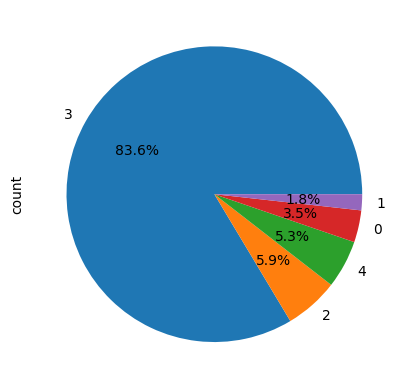

In [71]:
df['Label'].value_counts().plot(kind='pie', autopct='%.1f%%')

# Load Model

In [72]:
yamnet_url= 'https://tfhub.dev/google/yamnet/1'
yamnet = hub.load(yamnet_url)

# Pre Process Data

In [73]:
X = df['File Path']
y = df['Label']

In [74]:
def train_validate_test_split(df):
    df = df.sample(frac=1).reset_index(drop=True)
    train_end = int(.9 * len(df.index))
    validate_end = int(.05 * len(df.index)) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

In [75]:
# Split the DataFrame into training, validation, and test sets
df_train, df_validation, df_test = train_validate_test_split(df)

# Print the lengths of the splits
print(len(df_train), len(df_validation), len(df_test))

411 22 24


In [76]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['File Path'], df_train['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((df_validation['File Path'], df_validation['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['File Path'], df_test['Label']))

In [77]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [78]:
# def load_wav_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     file_contents = tf.io.read_file(filename)
#     print("File contents:", file_contents)  # Print file contents
#     wav, sample_rate = tf.audio.decode_wav(
#           file_contents,
#           desired_channels=1)
#     print("Sample rate:", sample_rate)  # Print sample rate
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav


In [79]:
def wav_map(file_path, label):
    return load_wav_16k_mono(file_path), label

In [80]:
# def wav_map(file_path, label):
#     wav_data = load_wav_16k_mono(file_path)

#     # Apply data augmentation (uncomment desired techniques)
#     # wav_data = speed_perturbation(wav_data)  # Optional
#     # wav_data = pitch_shift(wav_data, 16000)  # Optional (if defined)
#     # ... (other augmentation functions)

#     return wav_data, label


In [81]:
def extract_yamnet_embeddings(wav_data, targets):
    scores, embeddings, spectrogram = yamnet(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(targets, num_embeddings))

In [82]:
# # applies the embedding extraction model to a wav data
# def extract_embedding(wav_data, label, fold):
#   ''' run YAMNet to extract embedding from the wav data '''
#   scores, embeddings, spectrogram = yamnet_model(wav_data)
#   num_embeddings = tf.shape(embeddings)[0]
#   return (embeddings,
#             tf.repeat(label, num_embeddings),
#             tf.repeat(fold, num_embeddings))

In [83]:
# my_classes

# # extract embedding
# main_ds = main_ds.map(extract_embedding).unbatch()
# main_ds.element_spec

In [84]:
# def wav_map(file_path, label):
#   wav_data = load_wav_16k_mono(file_path)

#   # Apply data augmentation (uncomment desired techniques)
#   wav_data = speed_perturbation(wav_data, sample_rate)  # Optional (adjust speed range as needed)
#   # wav_data = pitch_shift(wav_data, 16000)  # Optional (if defined, adjust pitch shift factor)
#   # wav_data = time_stretch(wav_data, tf.random.uniform([], minval=0.95, maxval=1.05))  # Optional
#   # wav_data = add_noise(wav_data, 0.01)  # Optional (adjust noise level)

#   return wav_data, label

# def speed_perturbation(audio, sample_rate):
#     print("Shape of audio tensor:", audio.shape)  # Print shape of audio tensor
#     speed = tf.random.uniform([], minval=0.95, maxval=1.05)
#     num_samples = tf.cast(tf.shape(audio)[0], dtype=tf.float32) * speed
#     num_samples = tf.cast(num_samples, dtype=tf.int32)
#     audio = tfio.audio.resample(audio, sample_rate, num_samples)
#     return audio

# def pitch_shift(audio, sample_rate):
#   pitch_factor = tf.random.uniform([], minval=0.95, maxval=1.05)
#   return tf.signal.pitch_shift(audio, sample_rate, pitch_factor)

# def time_stretch(audio, rate):
#   return tf.audio.waveset_stretch(audio, rate)

# def add_noise(audio, noise_level):
#   noise = tf.random.normal(tf.shape(audio)) * noise_level
#   return audio + noise

# def process_dataset(dataset, sample_rate):
#     """Processes a dataset with data augmentation."""

#     def augment(features, labels, audio):
#         # Apply data augmentation (uncomment desired techniques)
#         audio = speed_perturbation(audio, sample_rate)  # Optional (adjust speed range as needed)

#         # Apply pitch shift (optional, uncomment if desired)
#         # audio = pitch_shift(audio, 16000)

#         # Apply time stretching (optional, uncomment if desired)
#         # audio = time_stretch(audio, tf.random.uniform([], minval=0.95, maxval=1.05))

#         # Apply background noise (optional, uncomment if desired)
#         # audio = add_noise(audio, 0.01)

#         return (audio, labels)

#     return (
#         dataset
#         .map(lambda audio, labels: augment(None, labels, audio))  # Adjusted to unpack audio and labels
#         .map(wav_map)  # Assuming wav_map preprocesses audio data further
#         .map(extract_yamnet_embeddings)  # Assuming this extracts features from audio
#         .unbatch()
#         .cache()
#         .shuffle(1000)
#         .batch(32)
#         .prefetch(tf.data.AUTOTUNE)
#     )

# sample_rate = 16000

# train_ds = process_dataset(train_ds, sample_rate)
# valid_ds = process_dataset(valid_ds, sample_rate)
# test_ds = process_dataset(test_ds, sample_rate)

In [85]:
def process_dataset(dataset):
    return (
        dataset
        .map(wav_map)
        .map(extract_yamnet_embeddings)
        .unbatch()
        .cache()
        .shuffle(1000)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )

train_ds = process_dataset(train_ds)
valid_ds = process_dataset(valid_ds)
test_ds = process_dataset(test_ds)

In [86]:
# def process_dataset_with_augmentation(dataset):
#     return (
#         dataset
#         .map(wav_map)
#         .map(extract_yamnet_embeddings)
#         .unbatch()
#         .cache()
#         .shuffle(1000)
#         .map(apply_audio_augmentation)  # Apply augmentation
#         .batch(32)
#         .prefetch(tf.data.AUTOTUNE)
#     )

# def apply_audio_augmentation(wav_data, label):
#     wav_data = tf.expand_dims(wav_data, axis=-1)
#     wav_data = kapre.augmentation.AdditiveNoise()(wav_data)
#     return tf.squeeze(wav_data, axis=-1), label

# # Process the datasets with augmentation
# train_ds = process_dataset_with_augmentation(train_ds)
# valid_ds = process_dataset(valid_ds)
# test_ds = process_dataset(test_ds)


In [87]:
# def wav_map(file_path, label):
#   wav_data = load_wav_16k_mono(file_path)

#   # Apply data augmentation (uncomment desired techniques)
#   wav_data = speed_perturbation(wav_data, sample_rate)  # Optional (adjust speed range as needed)
#   # wav_data = pitch_shift(wav_data, 16000)  # Optional (if defined, adjust pitch shift factor)
#   # wav_data = time_stretch(wav_data, tf.random.uniform([], minval=0.95, maxval=1.05))  # Optional
#   # wav_data = add_noise(wav_data, 0.01)  # Optional (adjust noise level)

#   return wav_data, label

# def speed_perturbation(audio, sample_rate):
#   speed = tf.random.uniform([], minval=0.95, maxval=1.05)
#   return tf.audio.set_speed(audio, speed)

# def pitch_shift(audio, sample_rate):
#   pitch_factor = tf.random.uniform([], minval=0.95, maxval=1.05)
#   return tf.signal.pitch_shift(audio, sample_rate, pitch_factor)

# def time_stretch(audio, rate):
#   return tf.audio.waveset_stretch(audio, rate)

# def add_noise(audio, noise_level):
#   noise = tf.random.normal(tf.shape(audio)) * noise_level
#   return audio + noise

# def process_dataset(dataset):
#   """Processes a dataset with data augmentation."""

#   def augment(features, labels, audio):
#     # Apply data augmentation (uncomment desired techniques)
#     audio = speed_perturbation(audio, sample_rate)  # Optional (adjust speed range as needed)

#     # Apply pitch shift (optional, uncomment if desired)
#     # audio = pitch_shift(audio, 16000)

#     # Apply time stretching (optional, uncomment if desired)
#     # audio = time_stretch(audio, tf.random.uniform([], minval=0.95, maxval=1.05))

#     # Apply background noise (optional, uncomment if desired)
#     # audio = add_noise(audio, 0.01)

#     return (audio, labels)

#   return (
#       dataset
#       .map(lambda features, labels: augment(features, labels, audio))  # Apply augmentation techniques here
#       .map(wav_map)  # Assuming wav_map preprocesses audio data further
#       .map(extract_yamnet_embeddings)  # Assuming this extracts features from audio
#       .unbatch()
#       .cache()
#       .shuffle(1000)
#       .batch(32)
#       .prefetch(tf.data.AUTOTUNE)
#   )


# train_ds = process_dataset(train_ds)
# valid_ds = process_dataset(valid_ds)
# test_ds = process_dataset(test_ds)

# Load Model

In [88]:
# tf.keras.backend.clear_session()

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

In [89]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),  # Assuming the YAMNet embeddings have a shape of (1024,)
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')  # Adjust the number of classes as needed
])

In [90]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [91]:
# history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=[early_stopping])

In [92]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
179/179 [==============================] - 23s 103ms/step - loss: 1.0568 - accuracy: 0.8252 - val_loss: 0.7715 - val_accuracy: 0.8618
Epoch 2/50
179/179 [==============================] - 1s 4ms/step - loss: 0.8561 - accuracy: 0.8371 - val_loss: 0.7223 - val_accuracy: 0.8618
Epoch 3/50
179/179 [==============================] - 1s 3ms/step - loss: 0.7888 - accuracy: 0.8373 - val_loss: 0.7023 - val_accuracy: 0.8618
Epoch 4/50
179/179 [==============================] - 0s 3ms/step - loss: 0.7511 - accuracy: 0.8367 - val_loss: 0.7201 - val_accuracy: 0.8618
Epoch 5/50
179/179 [==============================] - 0s 3ms/step - loss: 0.7336 - accuracy: 0.8374 - val_loss: 0.7295 - val_accuracy: 0.8618
Epoch 6/50
179/179 [==============================] - 0s 2ms/step - loss: 0.7205 - accuracy: 0.8373 - val_loss: 0.7142 - val_accuracy: 0.8618
Epoch 7/50
179/179 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.8371 - val_loss: 0.7126 - val_accuracy: 0.8618
Epo

In [93]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.056813,0.825197,0.771520,0.861842
1,0.856111,0.837095,0.722276,0.861842
2,0.788793,0.837270,0.702343,0.861842
3,0.751085,0.836745,0.720123,0.861842
4,0.733599,0.837445,0.729463,0.861842


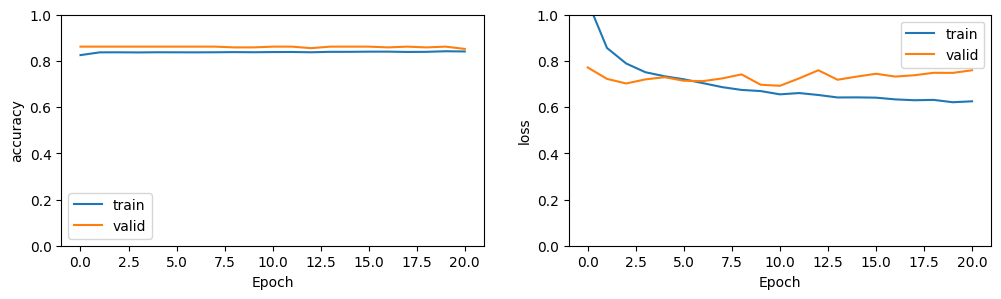

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0, 1])
    ax[i].legend(['train', 'valid'])

plt.show()

In [95]:
results = model.evaluate(test_ds, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

Test Loss: 1.016599416732788
Test Accuracy: 0.7910447716712952
